In [1]:
import os
import re
import json
from tqdm.notebook import tqdm
from textwrap import dedent

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import optimize 
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import utils

def scatter(w, k):
    return k * (1 / w**4)

def r_squared(y, y_hat):
    residuals = y - y_hat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared


root_dir_walk = os.walk('..')

plate_files = []

experiment_configs = {}

for dirpath, dirnames, filenames in root_dir_walk:
    if (e := re.search('\.\./([0-9]+)', dirpath)) is not None:
        experiment_number = int(e.group(1))
        data = {}
        if 1 <= experiment_number <= 22:
            #if experiment_number not in experiment_configs.keys():
            for filename in filenames:
                fpath = os.path.join(dirpath, filename)
                if filename.split('.')[-1] == 'CSV' and 'pathlength' not in filename.lower():
                    plate_files.append(fpath)
                if re.search('experiment-[0-9]+-summary\.csv', filename) is not None:
                    data['summary_fname'] = filename 
                    data['summary_path'] = fpath
                if re.search('config\_[0-9]+\.json', filename) is not None:
                    data['config_fname'] = filename 
                    if 'config' not in data.keys():
                        with open(fpath, 'r') as f:
                            data['config'] = json.load(f)
            if data != {}:
                experiment_configs[experiment_number] = data

configs_df = pd.concat([pd.read_csv(experiment_configs[i]['summary_path']) for i in experiment_configs]).reset_index(drop=True)

In [2]:
img_dir = 'img_scattering'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

## Concatente All Traces

## Trim $A < 300$

## Zero Traces at 800 nm

Commonly, traces are transformed in the $A$ direction by an amount equal to $A_{800}$

This is because of?

Join configs to traces

Uniformly subtracting $A_{800}$ from each trace cancels this effect, which has precedent?


In [3]:
df_ = pd.concat([utils.bmg.parse_bmg(i) for i in plate_files]) # raw traces
df = df_.reset_index(drop=True).subtract(df_[800].reset_index(drop=True), axis=0) # zeroed at 800 nm

df_clear = df.loc[df.loc[:, 300] < 0.2, :] # polystyrene plates
df_normal = df.loc[df.loc[:, 300] > 0.2, :] # polypropylene plates

# smooth traces
df_normal_smooth = pd.DataFrame(ndimage.gaussian_filter1d(df_normal.loc[:, 280:], 
                                                          sigma=5,
                                                          axis=1,), 
                                columns=df_normal.loc[:, 280:].columns, 
                                index=df_normal.index,
                               )

df_normal_smooth = df_normal_smooth.reset_index(drop=True).subtract(df_normal_smooth[800].reset_index(drop=True), axis=0)

# area under curve - for finding a baseline
auc = np.trapz(df_normal_smooth.loc[:, 300:].dropna(axis=1), axis=1)

# 
baseline = df_normal_smooth.iloc[auc.argmin(), :]

# normal (pp) plates, smoothed, baseline corrected
df_ns_corrected = df_normal_smooth.subtract(baseline, axis=1)

# colormap for auc
_auc_norm = auc - min(auc)
auc_norm = _auc_norm / max(_auc_norm)
auc_colors = plt.cm.inferno(auc_norm)

Cannot cast Index to dtype int64
Cannot cast Index to dtype int64


In [233]:
 def plot_traces(data, 
                ax=None,
                lw=0.5,
                c='#b4b4b4',
                colors=None,
                xlim=(220, 800),
                ylim=(-0.05, 3.5),
                legend_dict = None,
                **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, 
                               figsize=(14, 6),
                              )
        
    for i in tqdm(range(len(data))):
        row = data.iloc[i, :]
        ax.plot(row,
                lw=lw,
                c=c if colors is None else colors[i],
                alpha=kwargs.get('alpha'),
                )
        
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance')
    if (title:=kwargs.get('title')):
        ax.set_title(title)
    if isinstance(legend_dict, dict):
        patch_props = legend_dict.get('patch_props')
        legend_props = legend_dict.get('legend_props')
        assert all((patch_props, legend_props)), f"expected 'patch_props':list and 'legend_props': dict in legend_dict\nGot {', '.join(legend_dict.keys())}"
        handles, labels = ax.get_legend_handles_labels()
        for patch in patch_props:
            handles.append(mpatches.Patch(**patch))
        ax.legend(handles=handles, **legend_props)
    return ax
    
def add_cmap(fig, 
             ax, 
             vmin, 
             vmax,
             **kwargs):
    fig.colorbar(
                    plt.matplotlib.cm.ScalarMappable(
                                                    plt.matplotlib.colors.Normalize(vmin=vmin, vmax=vmax),
                                                    plt.colormaps['inferno'],
                                                    ),
                    ax=ax,
                    **kwargs
    )

  0%|          | 0/26160 [00:00<?, ?it/s]

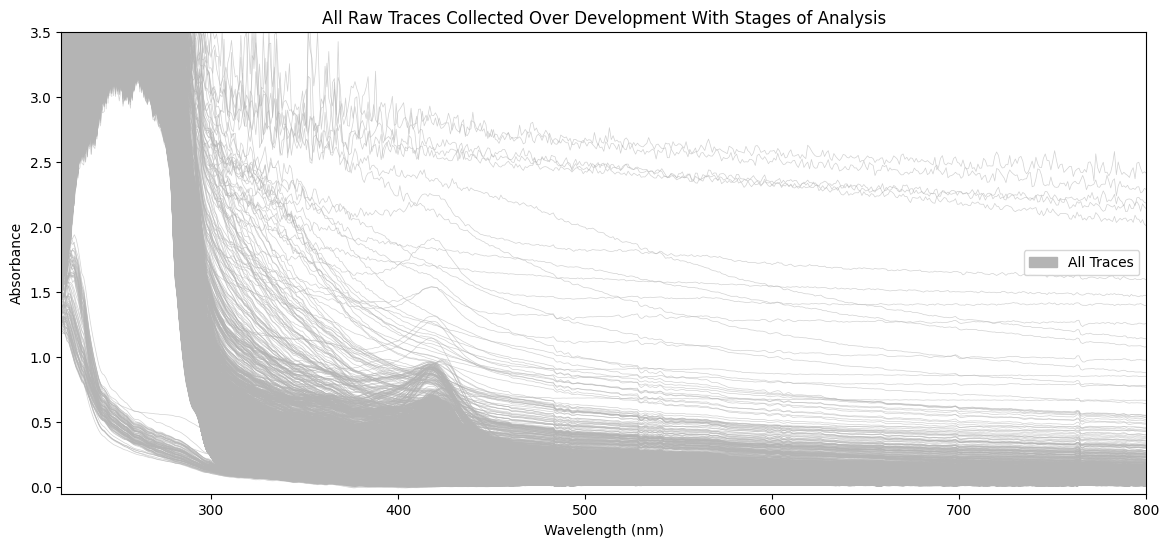

In [236]:
plot_traces(df_, 
            title='All Raw Traces Collected Over Development With Stages of Analysis',
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
            alpha=0.6,
           )

plt.savefig(os.path.join(img_dir, 'all-traces-raw.png'))
plt.show()

In [250]:
print(f'mean A 800: {df_[800].mean():.2f}')
print(f'std  A 800: {df_[800].std():.2f}')
print(f'cv   A 800: {df_[800].std() / df_[800].mean():.2f}')

mean A 800: 0.03
std  A 800: 0.05
cv   A 800: 1.36


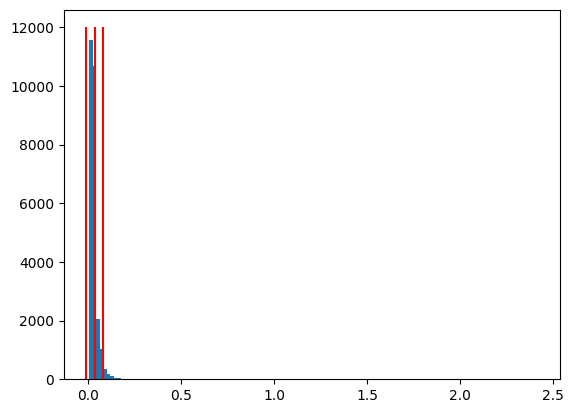

In [260]:
A_800_mean = df_[800].mean()
A_800_std = df_[800].std()
A_800_cv = df_[800].std() / df_[800].mean()

plt.hist(df_[800], 
         bins=128)
#plt.xscale('log')
plt.vlines(A_800_mean, 0, 12000, color='red')
plt.vlines(A_800_mean + A_800_std, 0, 12000, color='red')
plt.vlines(A_800_mean - A_800_std, 0, 12000, color='red')
plt.show()

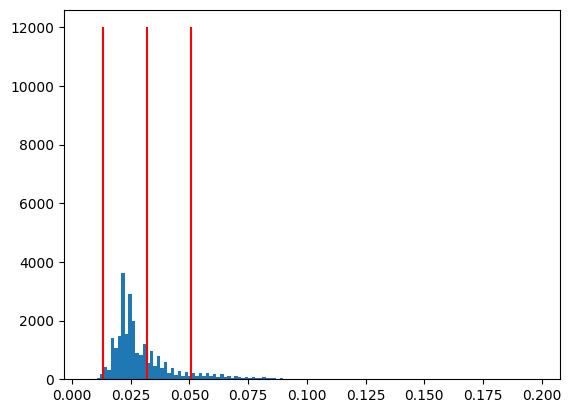

In [264]:
#df_slice = df_.loc[df_[800] < (A_800_mean + A_800_std), :]
df_slice = df_.loc[df_[800] < 0.2, :]
A_800_mean = df_slice[800].mean()
A_800_std = df_slice[800].std()
A_800_cv = df_slice[800].std() / df_slice[800].mean()

plt.hist(df_slice[800], 
         bins=128)
#plt.xscale('log')
plt.vlines(A_800_mean, 0, 12000, color='red')
plt.vlines(A_800_mean + A_800_std, 0, 12000, color='red')
plt.vlines(A_800_mean - A_800_std, 0, 12000, color='red')
plt.show()


  0%|          | 0/26056 [00:00<?, ?it/s]

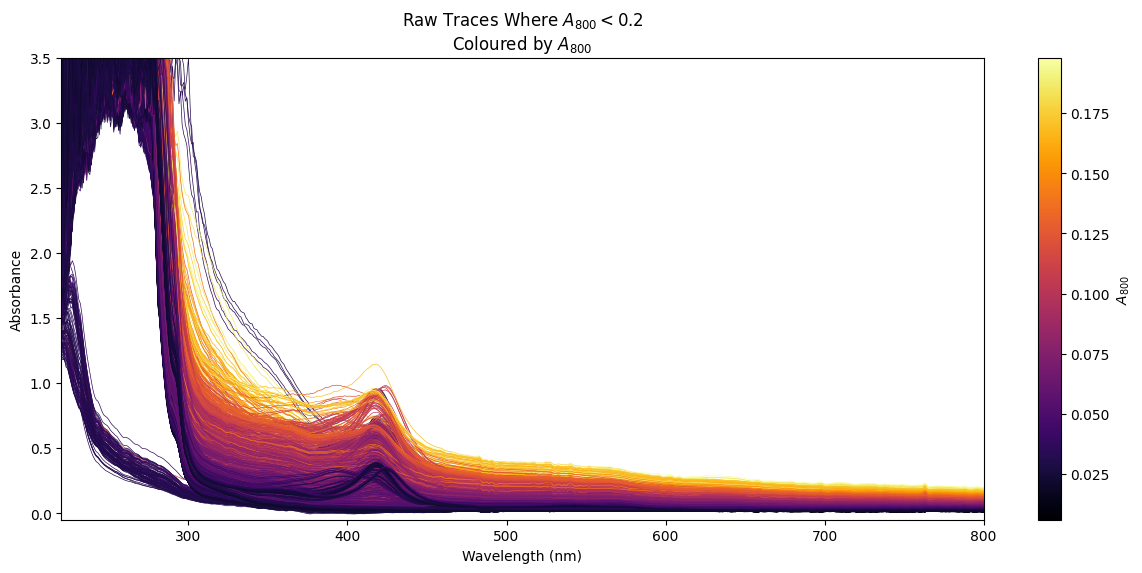

In [275]:
df__slice = df_.loc[df_[800] < 0.2, :]

fig, ax = plt.subplots(1, 1, figsize=(14,6))
plot_traces(df__slice, 
            ax=ax,
            title='Raw Traces Where $A_{800} < 0.2$\nColoured by $A_{800}$',
            alpha=1,
            colors=plt.cm.inferno(df__slice[800] / df__slice[800].max())
           )


add_cmap(fig, 
         ax=ax, 
         vmin=min(df__slice[800]), 
         vmax=max(df__slice[800]), 
         label='$A_{800}$', 
         orientation='vertical',
         fraction=0.1,
        )
plt.savefig(os.path.join(img_dir, 'traces-a800-lt-pt2-color-a800.png'))
plt.show()

  0%|          | 0/26160 [00:00<?, ?it/s]

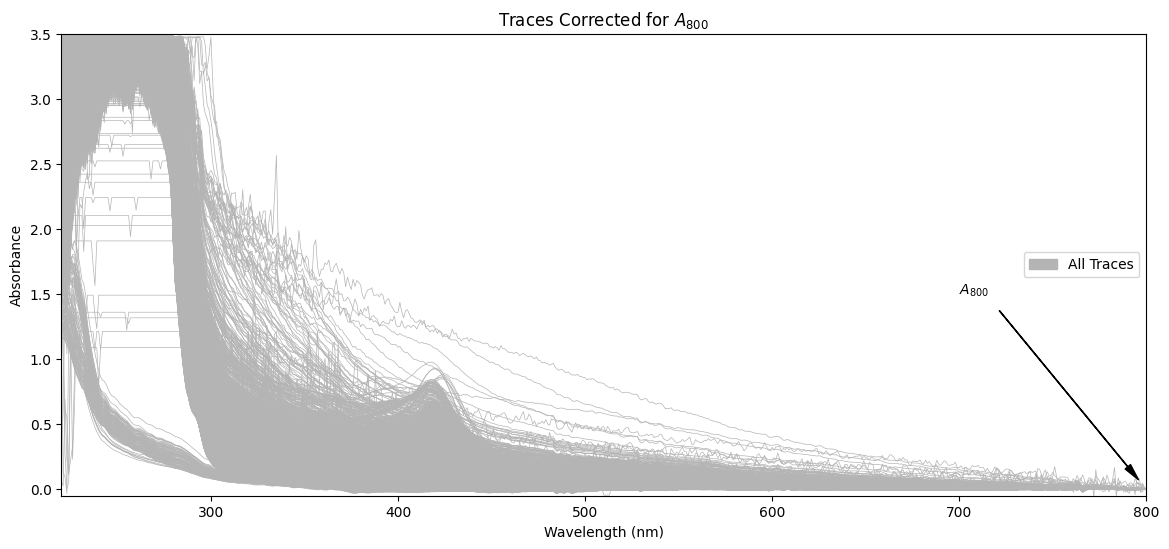

In [6]:
ax = plot_traces(df, 
            title='Traces Corrected for $A_{800}$',
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

ax.annotate('$A_{800}$', 
               xy=(800, 0), 
               xytext=(700, 1.5),
               arrowprops=dict(width=0.2, 
                               headwidth=5,
                               shrink=0.05,
                               facecolor='black',
                               )
              )
plt.savefig(os.path.join(img_dir, 'all-traces-zero.png'))
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

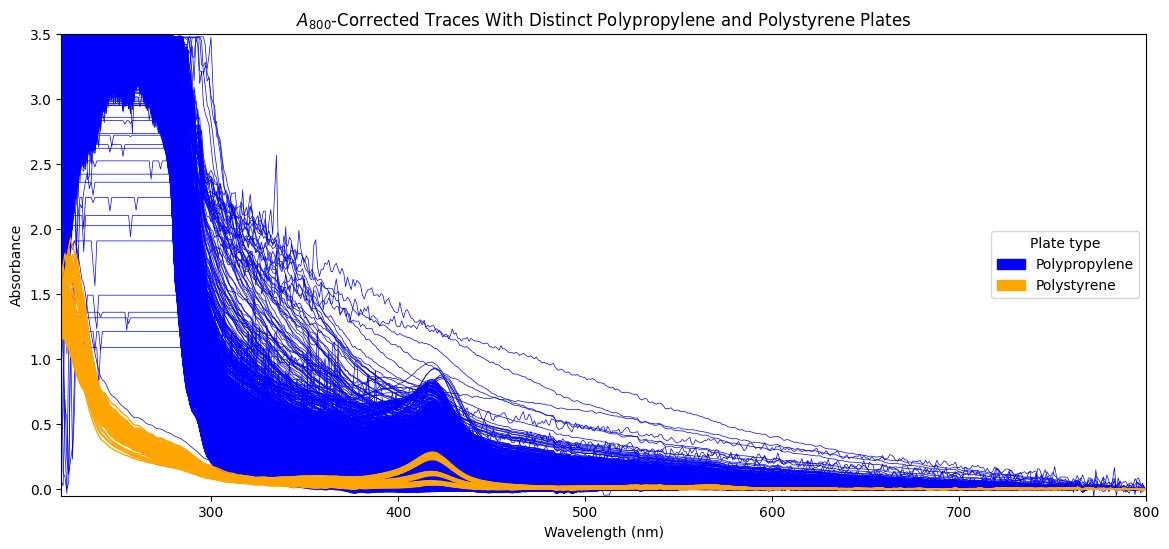

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

plot_traces(df_normal, 
            ax=ax,
            c='blue', 
            title='$A_{800}$-Corrected Traces With Distinct Polypropylene and Polystyrene Plates',
           )

plot_traces(df_clear, 
            ax=ax,
            c='orange', 
            lw=1,
            legend_dict={
                'patch_props': [
                    {'color': 'blue',   'label':'Polypropylene'},
                    {'color': 'orange', 'label':'Polystyrene'},
                ],
                
                'legend_props': {'title': 'Plate type',   'loc':'right'},
            }
           )
plt.savefig(os.path.join(img_dir, 'plate-type.png'))
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

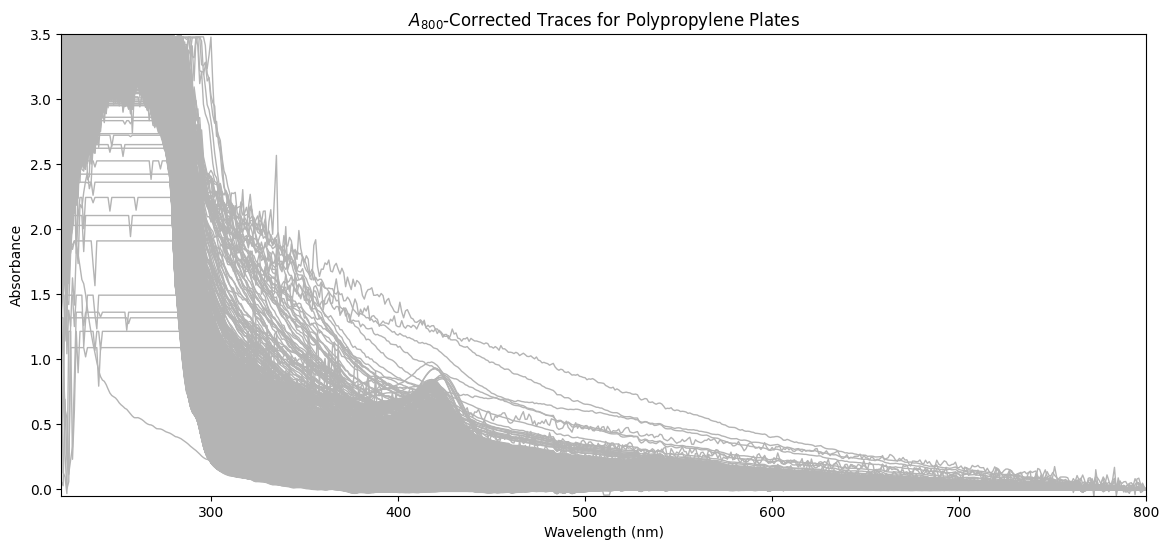

In [8]:
plot_traces(df_normal, 
            title='$A_{800}$-Corrected Traces for Polypropylene Plates', lw=1,
           )
plt.savefig(os.path.join(img_dir, 'pp-traces.png'))
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

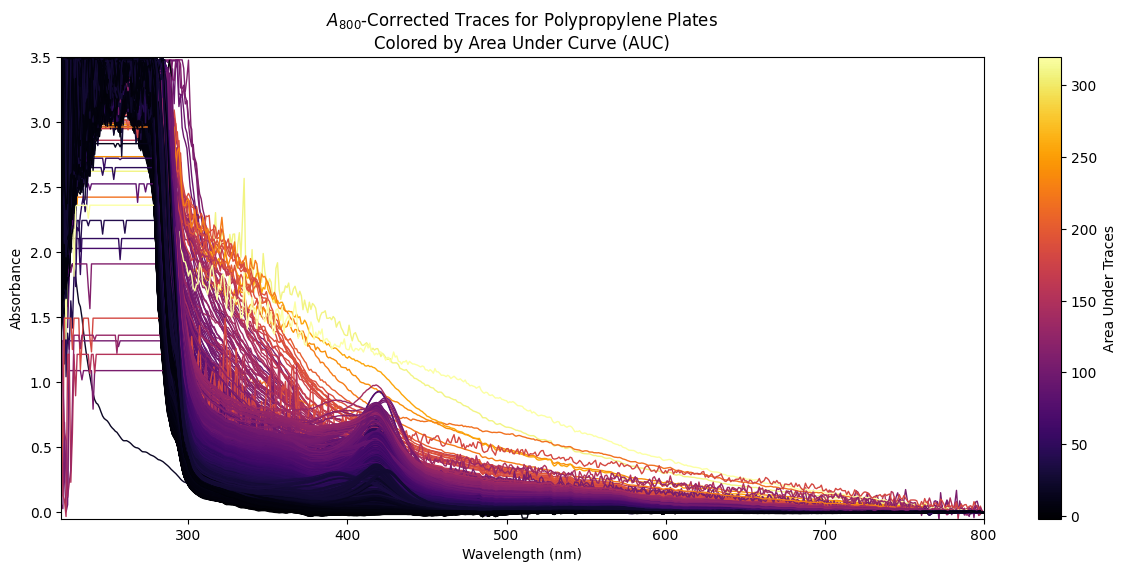

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

plot_traces(df_normal, 
            ax=ax,
            title='$A_{800}$-Corrected Traces for Polypropylene Plates\nColored by Area Under Curve (AUC)', 
            lw=1, 
            colors=auc_colors,
            )

add_cmap(fig, 
         ax=ax, 
         vmin=min(auc), 
         vmax=max(auc), 
         label='Area Under Traces', 
         orientation='vertical',
         fraction=0.1,
        )

plt.savefig(os.path.join(img_dir, 'pp-traces.png'))
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

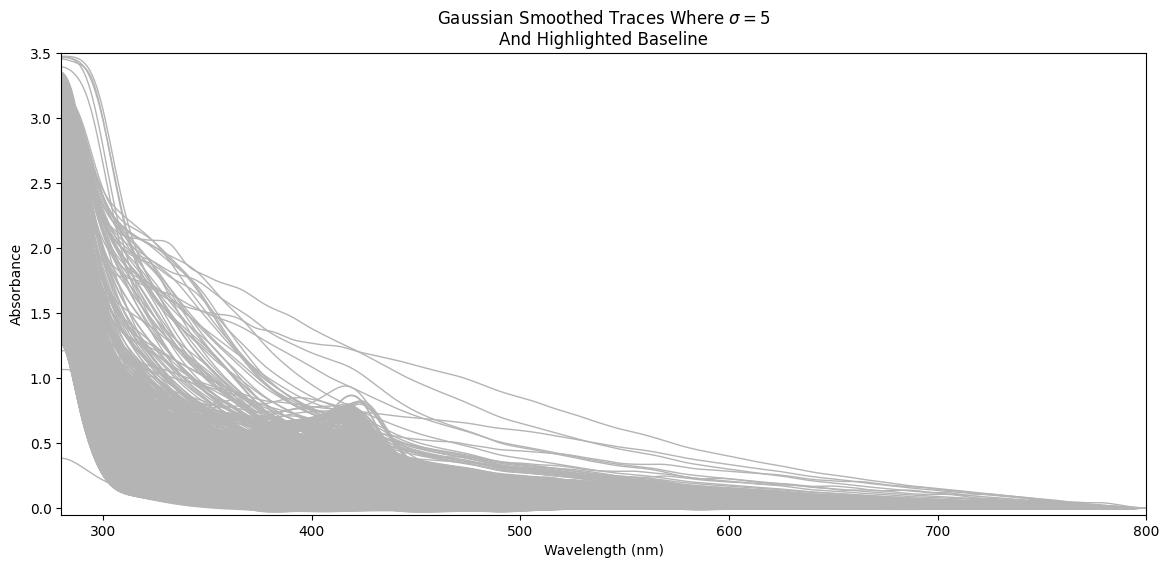

In [10]:
plot_traces(df_normal_smooth, 
            title='Gaussian Smoothed Traces Where $\sigma = 5$\nAnd Highlighted Baseline', 
            lw=1, 
            xlim=(280, 800),
           )

plt.savefig(os.path.join(img_dir, 'smooth-traces.png'))
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

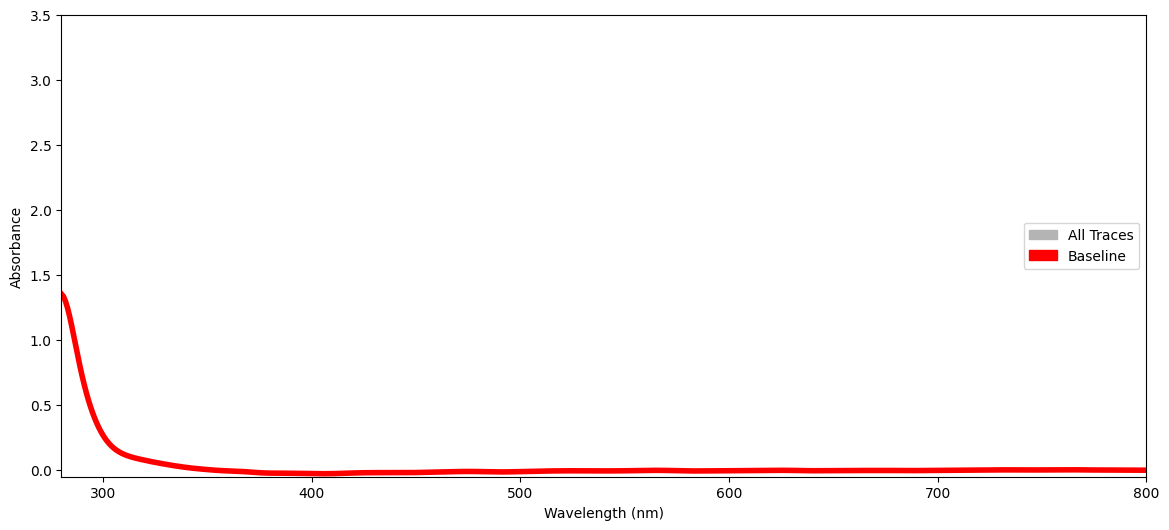

In [11]:
plot_traces(pd.DataFrame(baseline).T, 
            lw=4, 
            c='red', 
            xlim=(280, 800),
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                    {'color': 'red',   'label': 'Baseline'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

plt.savefig(os.path.join(img_dir, 'smooth-baseline.png'))
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

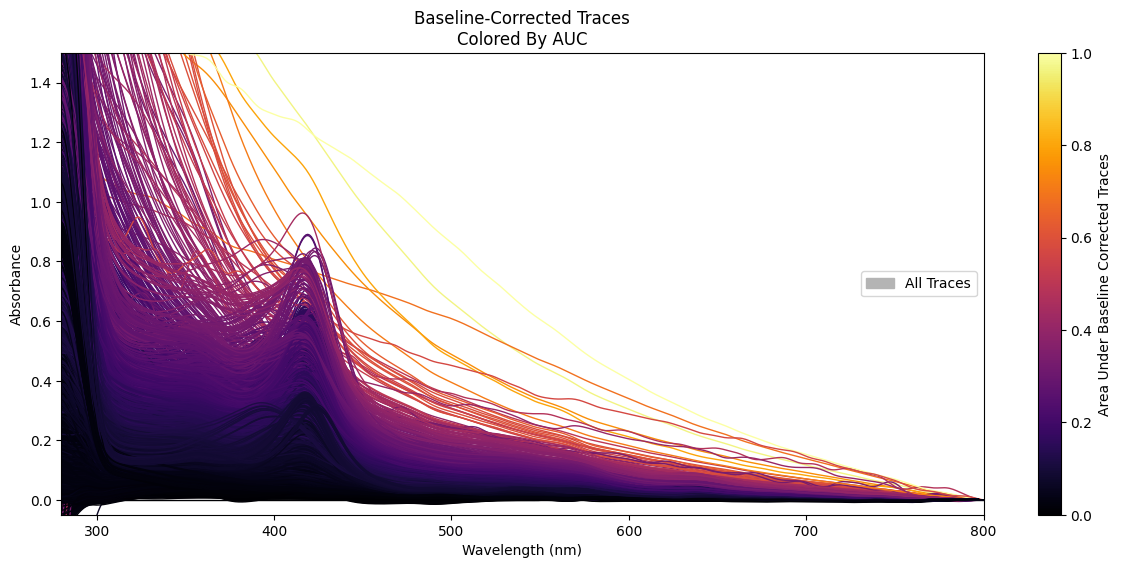

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

plot_traces(df_ns_corrected, 
            ax, 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=auc_colors, 
            title='Baseline-Corrected Traces\nColored By AUC',
           )


add_cmap(fig, 
         ax, 
         vmin=min(auc_norm), 
         vmax=max(auc_norm), 
         label='Area Under Baseline Corrected Traces', 
         orientation='vertical',
         fraction=0.1,
)

plt.savefig(os.path.join(img_dir, 'smooth-corrected-auc.png'))
plt.show()

  0%|          | 0/26160 [00:00<?, ?it/s]

  0%|          | 0/26160 [00:00<?, ?it/s]

  0%|          | 0/26065 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/26065 [00:00<?, ?it/s]

  0%|          | 0/26065 [00:00<?, ?it/s]

  0%|          | 0/26065 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/26065 [00:00<?, ?it/s]

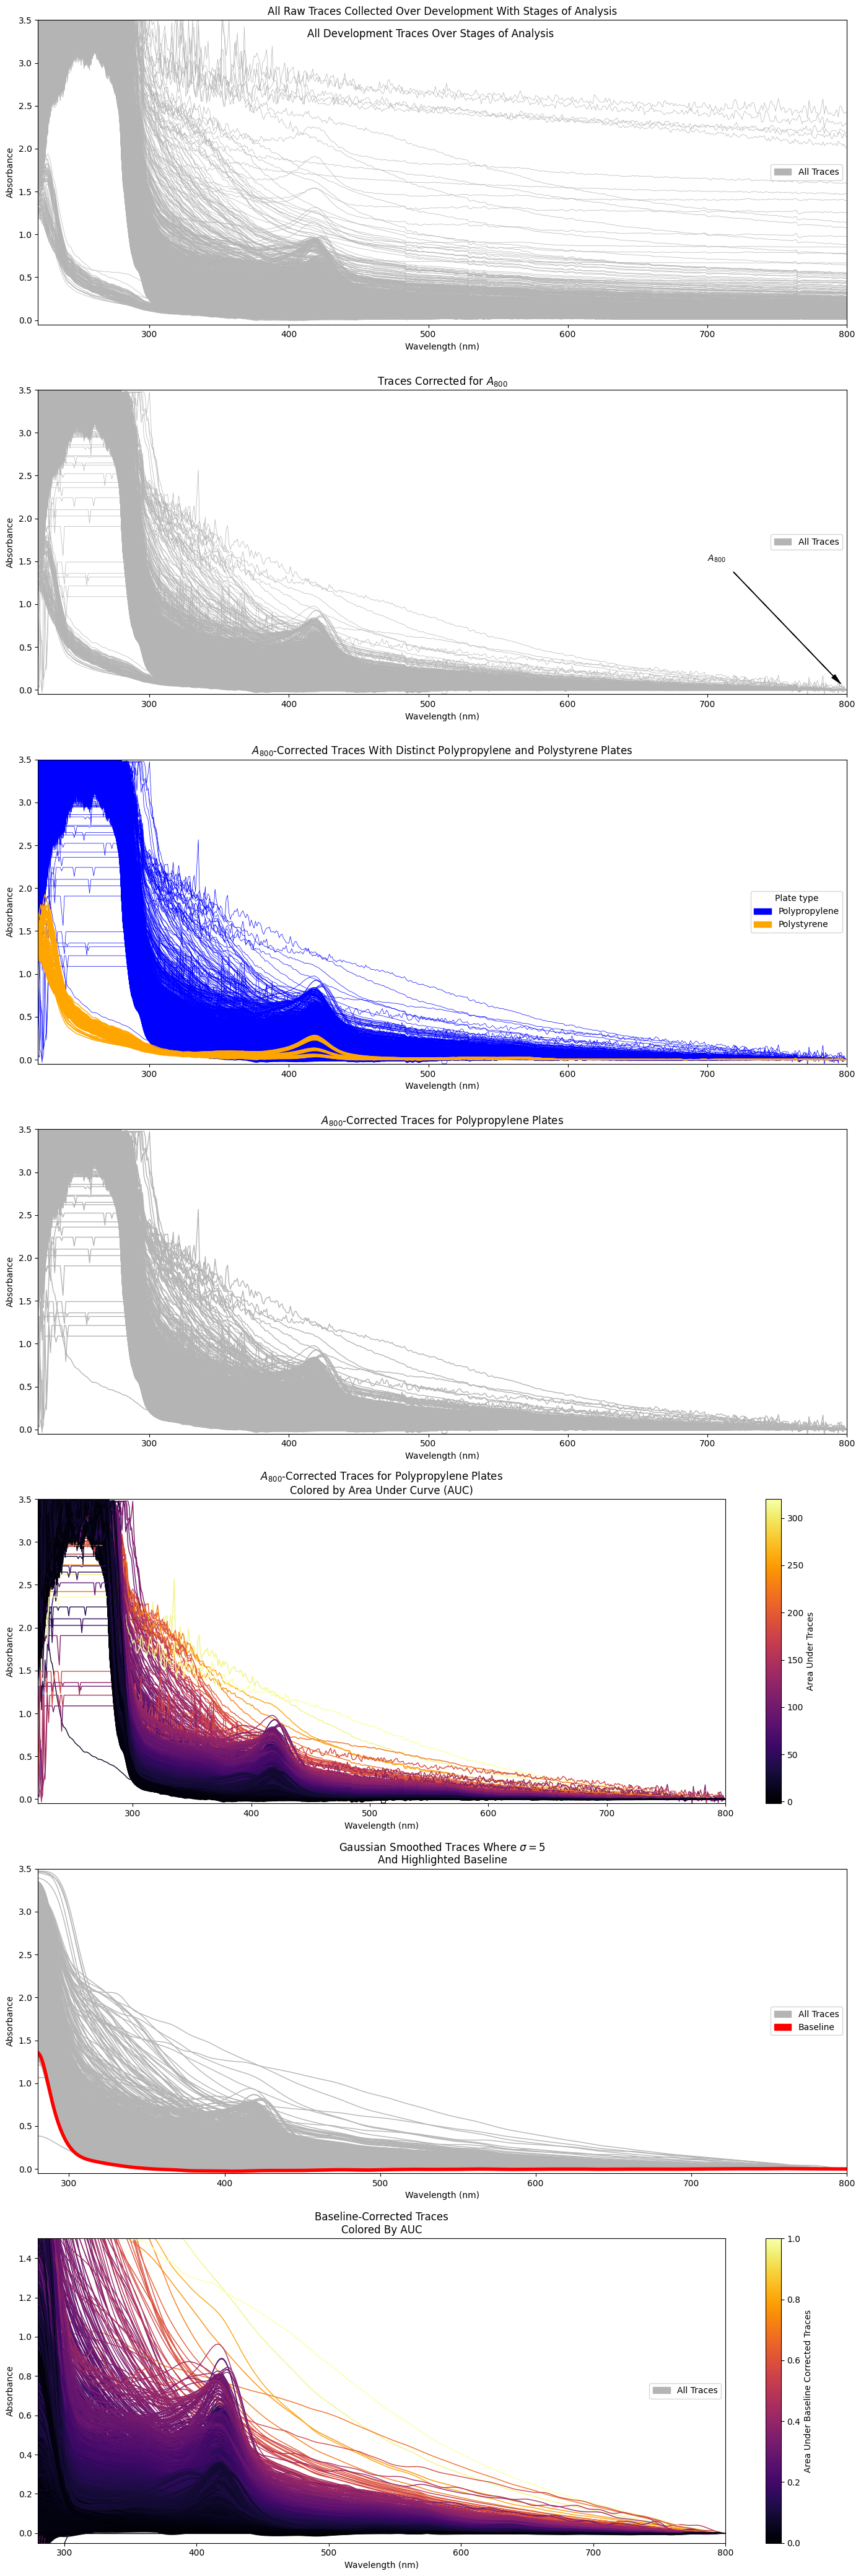

In [13]:
    
n_plots = 7
fig, ax = plt.subplots(n_plots, 1, 
                       figsize=(14, n_plots*6),
                      )

plot_traces(df_, 
            ax[0], 
            title='All Raw Traces Collected Over Development With Stages of Analysis',
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

plot_traces(df, 
            ax[1], 
            title='Traces Corrected for $A_{800}$',
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

ax[1].annotate('$A_{800}$', 
               xy=(800, 0), 
               xytext=(700, 1.5),
               arrowprops=dict(width=0.2, 
                               headwidth=5,
                               shrink=0.05,
                               facecolor='black',
                               )
              )

plot_traces(df_normal, 
            ax[2], 
            c='blue', 
            title='$A_{800}$-Corrected Traces With Distinct Polypropylene and Polystyrene Plates',
           )

plot_traces(df_clear, 
            ax[2], 
            c='orange', 
            lw=1,
            legend_dict={
                'patch_props': [
                    {'color': 'blue',   'label':'Polypropylene'},
                    {'color': 'orange', 'label':'Polystyrene'},
                ],
                
                'legend_props': {'title': 'Plate type',   'loc':'right'},
            }
           )

plot_traces(df_normal, 
            ax[3], 
            title='$A_{800}$-Corrected Traces for Polypropylene Plates', lw=1,
           )

plot_traces(df_normal, 
            ax[4], 
            title='$A_{800}$-Corrected Traces for Polypropylene Plates\nColored by Area Under Curve (AUC)', 
            lw=1, 
            colors=auc_colors,
           )

add_cmap(fig, 
         ax[4], 
         vmin=min(auc), 
         vmax=max(auc), 
         label='Area Under Traces', 
         fraction=0.1,
         orientation='vertical',
        )

plot_traces(df_normal_smooth, 
            ax[5], 
            title='Gaussian Smoothed Traces Where $\sigma = 5$\nAnd Highlighted Baseline', 
            lw=1, 
            xlim=(280, 800),
           )

plot_traces(pd.DataFrame(baseline).T, 
            ax[5], 
            lw=4, 
            c='red', 
            xlim=(280, 800),
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                    {'color': 'red',   'label': 'Baseline'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

plot_traces(df_ns_corrected, 
            ax[6], 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=auc_colors, 
            title='Baseline-Corrected Traces\nColored By AUC',
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4',   'label': 'All Traces'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )


add_cmap(fig, 
         ax[6], 
         vmin=min(auc_norm), 
         vmax=max(auc_norm), 
         label='Area Under Baseline Corrected Traces', 
         fraction=0.1,
         orientation='vertical',
        )

fig.suptitle('All Development Traces Over Stages of Analysis')
plt.tight_layout()

plt.savefig(os.path.join(img_dir, 'all_traces.png'))
plt.show()

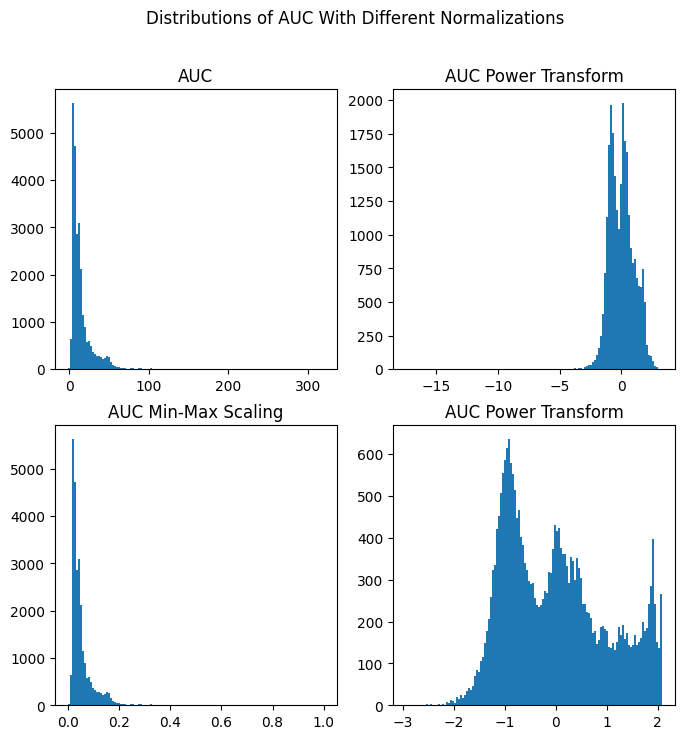

In [14]:
from sklearn.preprocessing import PowerTransformer

transformer_auc = PowerTransformer()
transformer_auc_norm = PowerTransformer()
auc_power = transformer_auc.fit_transform(auc.reshape(-1, 1))
auc_norm_power = transformer_auc_norm.fit_transform(auc_norm.reshape(-1, 1))

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0, 0].hist(auc, bins=128)
ax[0, 0].set_title('AUC')

ax[0, 1].hist(auc_power, bins=128)
ax[0, 1].set_title('AUC Power Transform')

ax[1, 0].hist(auc_norm, bins=128)
ax[1, 0].set_title('AUC Min-Max Scaling')

ax[1, 1].hist(auc_norm_power, bins=128)
ax[1, 1].set_title('AUC Power Transform')

fig.suptitle('Distributions of AUC With Different Normalizations')
plt.savefig(os.path.join(img_dir, 'AUC-distributions.png'))
plt.show()

## 

  0%|          | 0/10333 [00:00<?, ?it/s]

  0%|          | 0/10333 [00:00<?, ?it/s]

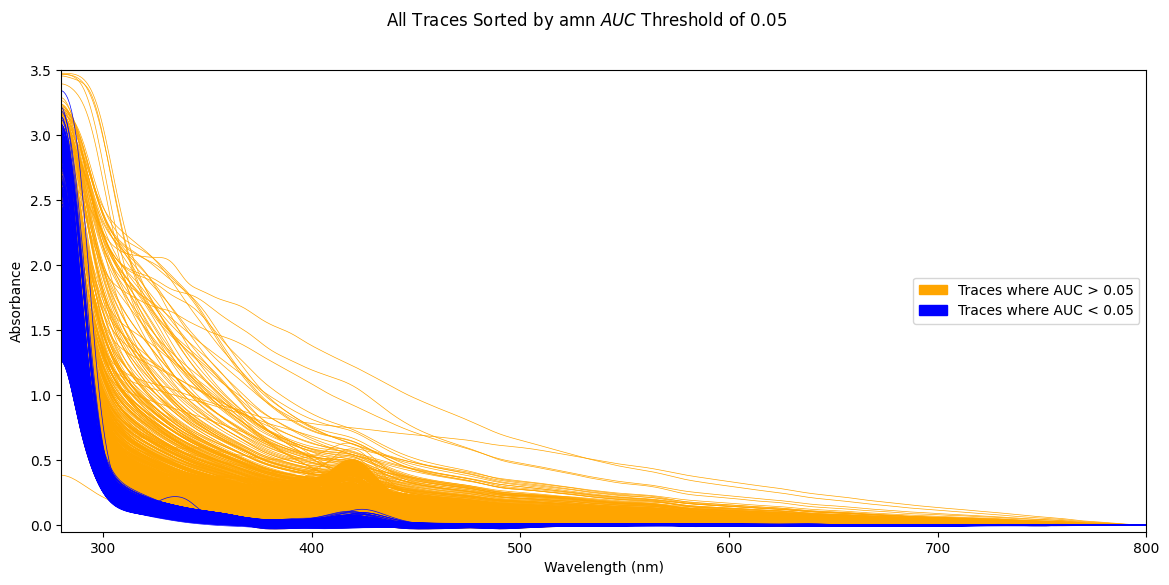

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

threshhold = -0.5
threshhold_inverse = transformer_auc_norm.inverse_transform([[0.5]])[0][0]

index_gt_thresh, _ = np.where(auc_norm_power[np.where(auc_norm_power < threshhold)[0]] < 1)

plot_traces(df_normal_smooth.loc[index_gt_thresh, :], 
            #colors=auc_norm_power_colors[index],
            c='orange',
            ax=ax
           )

index_lt_thresh, _ = np.where(auc_norm_power < threshhold)

plot_traces(df_normal_smooth.loc[index_lt_thresh, :], 
            #colors=auc_norm_power_colors[index],
            c='blue',
            ax=ax,
            legend_dict={
                'patch_props': [
                    {'color': 'orange', 'label': f'Traces where AUC > {threshhold_inverse:.2f}'},
                    {'color': 'blue', 'label': f'Traces where AUC < {threshhold_inverse:.2f}'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

ax.set_xlim(280, 800)
fig.suptitle(f'All Traces Sorted by amn $AUC$ Threshold of {threshhold_inverse:.2f}')
plt.savefig(os.path.join(img_dir, 'all-traces-auc-thresh.png'))
plt.show()

## Distribution of Raw $A_{800}$

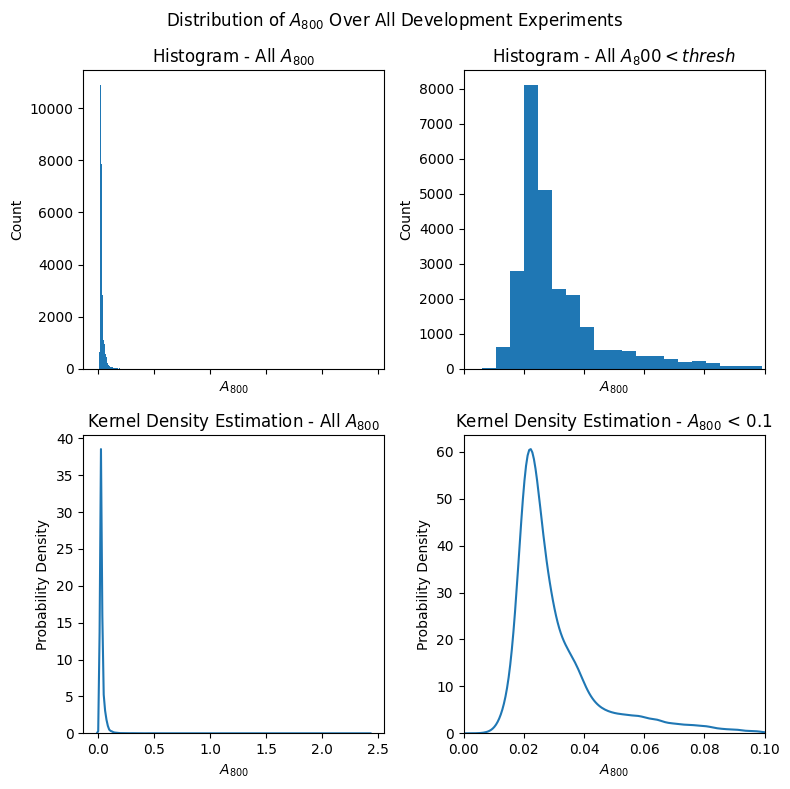

In [16]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex='col')

ax[0, 0].hist(df_[800], bins=256)
ax[0, 0].set_title('Histogram - All $A_{800}$')
ax[0, 0].set_ylabel('Count')
ax[0, 0].set_xlabel('$A_{800}$')

#ax[0].set_xlim(0, 1)

sns.kdeplot(df_[800], 
            ax=ax[1, 0],
           )

ax[1, 0].set_ylabel('Probability Density')
ax[1, 0].set_title('Kernel Density Estimation - All $A_{800}$')
ax[1, 0].set_xlabel('$A_{800}$')

thresh = 0.1

ax[0, 1].hist(df_.loc[df_[800] < thresh, 800], bins=20)
ax[0, 1].set_ylabel('Count')
ax[0, 1].set_title(f'Histogram - All $A_{800} < {{thresh}}$')
ax[0, 1].set_xlabel('$A_{800}$')

#ax[0].set_xlim(0, 1)

sns.kdeplot(df_.loc[df_[800] < thresh, 800], 
            ax=ax[1, 1],
           )
ax[1, 1].set_ylabel('Probability Density')
ax[1, 1].set_title(f'Kernel Density Estimation - $A_{{800}}$ < {thresh}')
ax[1, 1].set_xlabel('$A_{800}$')
ax[1, 1].set_xlim(0, thresh)


fig.suptitle('Distribution of $A_{800}$ Over All Development Experiments')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'a800-hist.png'))
plt.show()

## Figure: Before and After $A_{801}$ Normalization

In [17]:
# df_normal_smooth = pd.DataFrame(ndimage.gaussian_filter1d(df_normal, 
#                                                           sigma=5,
#                                                           axis=1,), 
#                                 columns=df_normal.columns, 
#                                 index=df_normal.index,
#                                )
# 
# df_normal_smooth =  df_normal_smooth.subtract(df_normal_smooth[800], axis=0)
# 
# auc_smooth = np.trapz(df_normal_smooth, axis=1)
# _auc_norm_smooth = auc_smooth - min(auc_smooth)
# auc_norm_smooth = _auc_norm_smooth / max(_auc_norm_smooth)

## Smooth Traces

Following steps include subtraction of blank wells, where small random noise can interfere.
Smoothing the traces with Guassian smoothing mitigates the effects of the noise whilst preserving the macro 
features of interest (the P450 peaks)

## Figure: Before and After Smoothing

Or different $\sigma$ paramaters for comparison - need to justify a choice for $\sigma$

## AUC

In [18]:
# auc = np.trapz(df_normal, axis=1)
# _auc_norm = auc - min(auc)
# auc_norm = _auc_norm / max(_auc_norm)
# 
# 
# auc_smooth = np.trapz(df_normal_smooth, axis=1)
# _auc_norm_smooth = auc_smooth - min(auc_smooth)
# auc_norm_smooth = _auc_norm_smooth / max(_auc_norm_smooth)
# 

## Baseline Subtraction

- Each individual trace and corresponding control
- Ideal Baseline - presumed plate inherent absorbance

In [19]:
# baseline = df_normal.iloc[auc.argmin(), :]
# sigma = 5
# baseline_smooth = pd.Series(ndimage.gaussian_filter1d(baseline, sigma=sigma), index=baseline.index)
# baseline_smooth -= baseline_smooth[800]
# 
# baseline = df_normal_smooth.iloc[auc_norm_smooth.argmin(), :]
# 
# df_normal_smooth = df_normal_smooth - baseline_smooth

## Scattering Curve Fitting

In [20]:
all_rsq = []
all_k = []

for i in tqdm(range(len(df_ns_corrected))):
    row = df_ns_corrected.iloc[i, :].dropna()
    k, cov = optimize.curve_fit(scatter,
                                xdata=row.index,
                                ydata=row
                               )
    y_pred = pd.Series(scatter(row.index, k), index=row.index)
    rsq = r_squared(row, y_pred)
    all_rsq.append(rsq)
    all_k.append(k)
    
ks = np.concatenate(all_k).reshape(-1, 1)
rsqs = np.array(all_rsq)

power_scaler = PowerTransformer()
power_scaler.fit(ks)

def color_k(k):
    k_norm = power_scaler.transform(np.array(k).reshape(1,1)).flatten()
    return plt.cm.inferno(k_norm)
    
metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
metrics_df_kslice = metrics_df.loc[metrics_df['Rsq'] > 0, :]

# df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]

  0%|          | 0/26065 [00:00<?, ?it/s]

/tmp/ipykernel_3613287/4196109192.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  k, cov = optimize.curve_fit(scatter,
/tmp/ipykernel_3613287/3956004560.py:25: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


## Exclusion Threshold

  0%|          | 0/23801 [00:00<?, ?it/s]

  0%|          | 0/23801 [00:00<?, ?it/s]

  0%|          | 0/4049 [00:00<?, ?it/s]

  0%|          | 0/4049 [00:00<?, ?it/s]

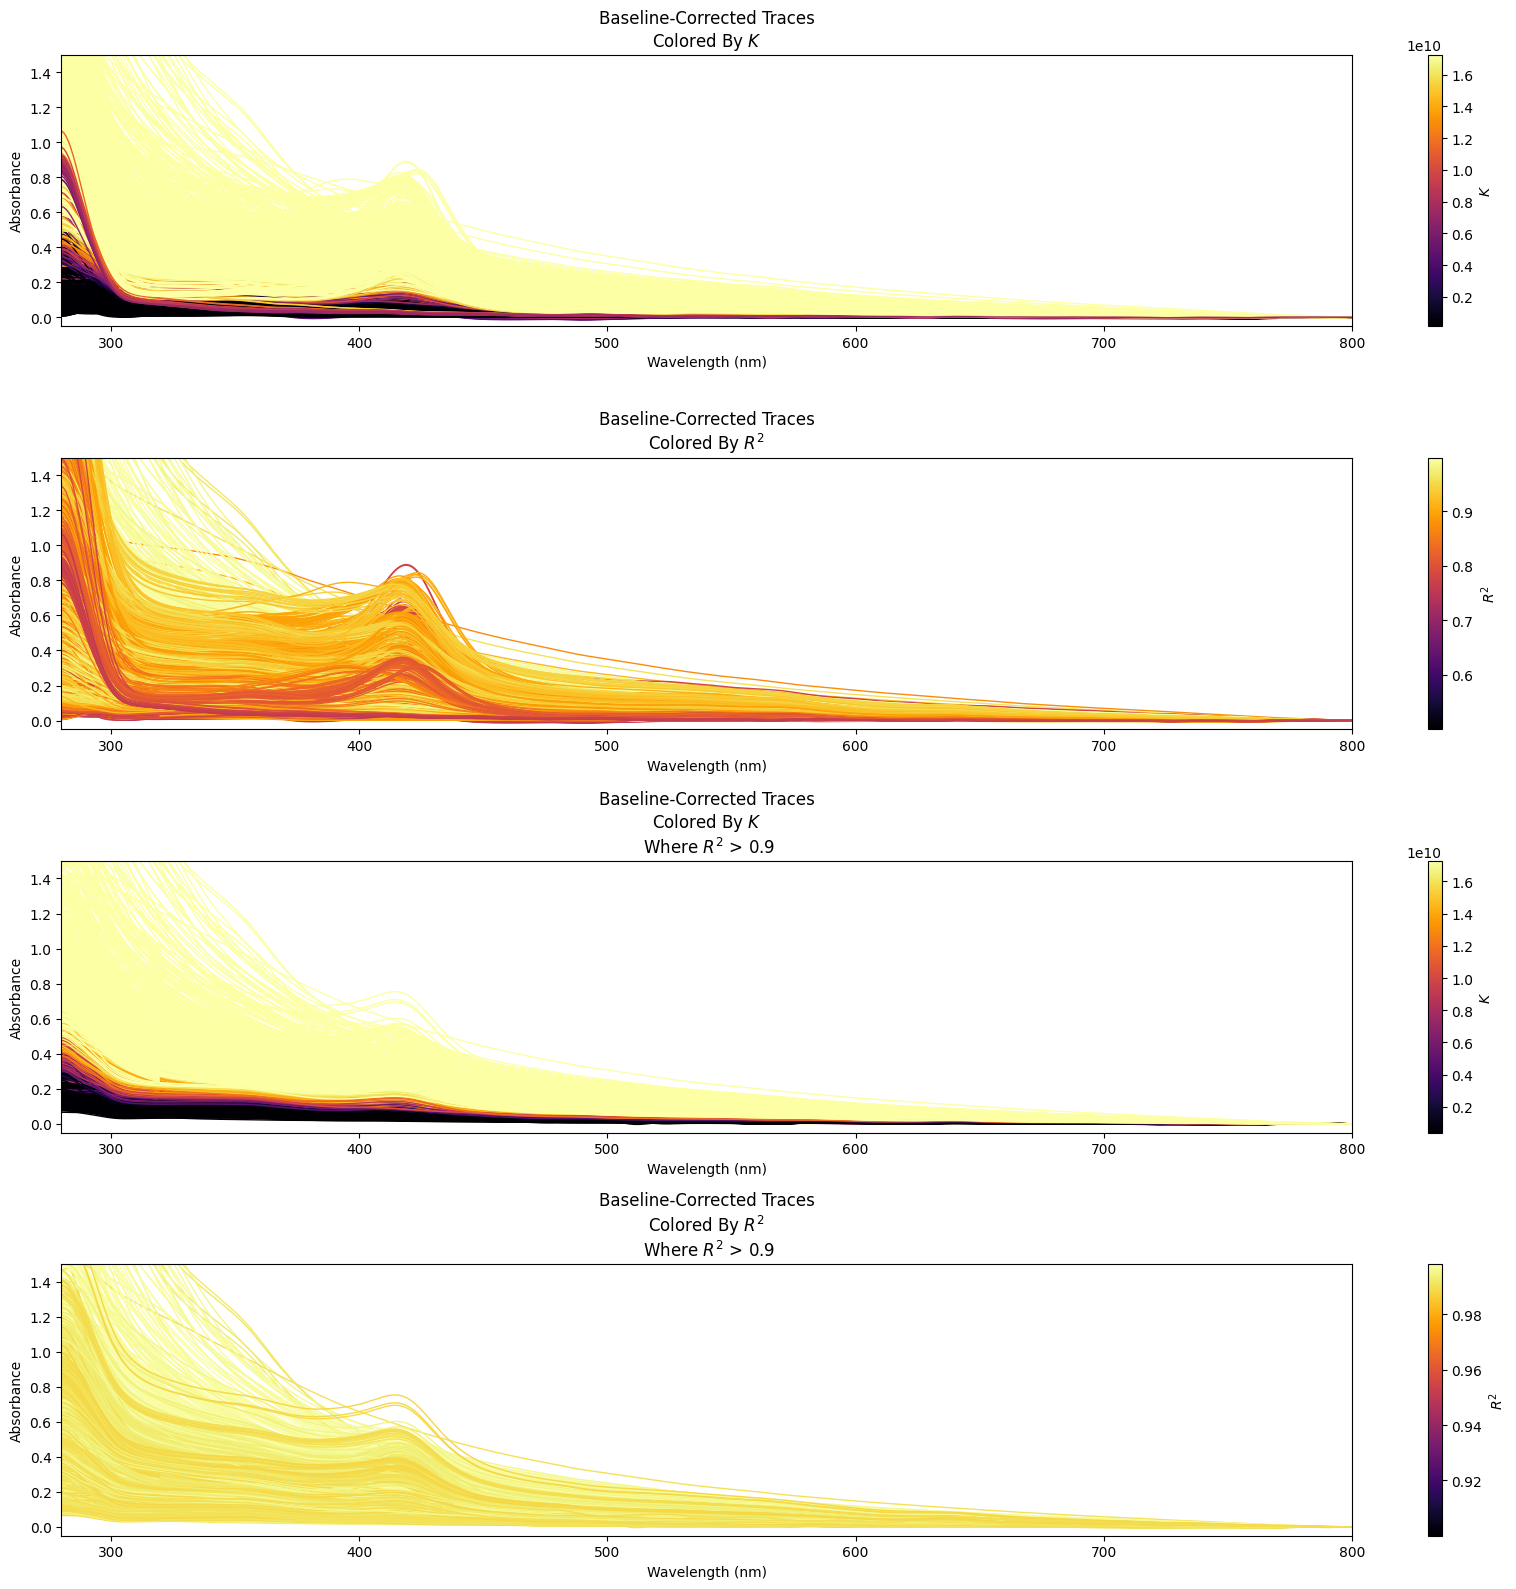

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(16,4*4))

 
rsq_idx = np.array(all_rsq) > 0.5
df_ns_slice = df_ns_corrected.loc[rsq_idx, :]

all_rsq_slice = [i for i, j in zip(all_rsq, rsq_idx) if j]
all_k_slice = [i for i, j in zip(all_k, rsq_idx) if j]

k_cmap = plt.cm.inferno(power_scaler.fit_transform(np.array(all_k_slice)))
rsq_cmap = plt.cm.inferno(all_rsq_slice)

plot_traces(df_ns_slice, 
            ax[0], 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=k_cmap, 
            title='Baseline-Corrected Traces\nColored By $K$',
           )

add_cmap(fig, 
         ax[0], 
         vmin=min(all_k_slice), 
         vmax=max(all_k_slice), 
         label='$K$', 
         orientation='vertical',
         fraction=0.1,
        )

plot_traces(df_ns_slice, 
            ax[1], 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=rsq_cmap, 
            title='Baseline-Corrected Traces\nColored By $R^2$',
           )

add_cmap(fig, 
         ax[1], 
         vmin=min(all_rsq_slice), 
         vmax=max(all_rsq_slice), 
         label='$R^2$', 
         orientation='vertical',
         fraction=0.1,
        )

rsq_idx = np.array(all_rsq) > 0.9
df_ns_slice = df_ns_corrected.loc[rsq_idx, :]

all_rsq_slice = [i for i, j in zip(all_rsq, rsq_idx) if j]
all_k_slice = [i for i, j in zip(all_k, rsq_idx) if j]

k_cmap = plt.cm.inferno(power_scaler.fit_transform(np.array(all_k_slice)))
rsq_cmap = plt.cm.inferno(all_rsq_slice)

plot_traces(df_ns_slice, 
            ax[2], 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=k_cmap, 
            title='Baseline-Corrected Traces\nColored By $K$\n Where $R^2$ > 0.9',
           )

add_cmap(fig, 
         ax[2], 
         vmin=min(all_k_slice), 
         vmax=max(all_k_slice), 
         label='$K$', 
         orientation='vertical',
         fraction=0.1,
        )

plot_traces(df_ns_slice, 
            ax[3], 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=rsq_cmap, 
            title='Baseline-Corrected Traces\nColored By $R^2$\n Where $R^2$ > 0.9',
           )

add_cmap(fig, 
         ax[3], 
         vmin=min(all_rsq_slice), 
         vmax=max(all_rsq_slice), 
         label='$R^2$', 
         orientation='vertical',
         fraction=0.1,
        )

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'all-traces-color-k-rsq.png'))
plt.show()

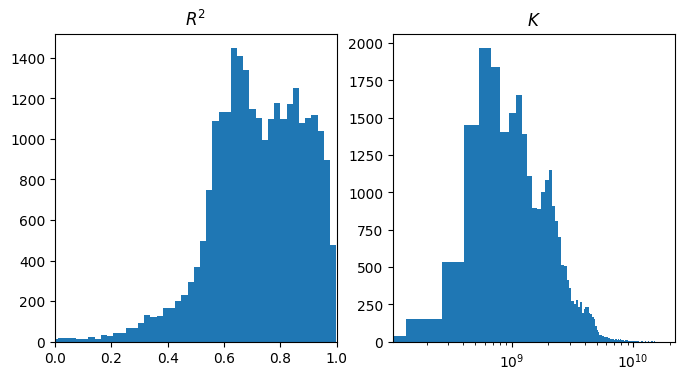

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].hist(all_rsq, bins=128)
ax[0].set_xlim(0, 1)
ax[0].set_title('$R^2$')

ax[1].hist(np.array(all_k), bins=128)
#ax[1].set_xlim(0, 1)
ax[1].set_title('$K$')
ax[1].set_xscale('log')

plt.savefig(os.path.join(img_dir, 'k-rsq-hist.png'))
plt.show()

  0%|          | 0/4049 [00:00<?, ?it/s]

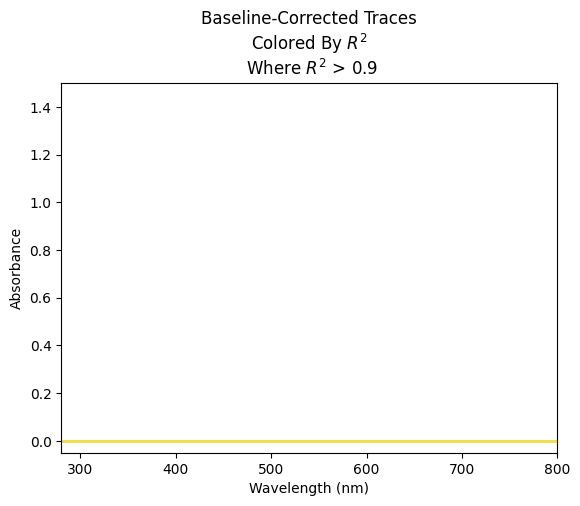

In [23]:
rsq_idx = np.array(all_rsq) > 0.5
df_ns_slice = df_ns_corrected.loc[rsq_idx, :]

k_cmap = plt.cm.inferno(power_scaler.fit_transform(np.array(all_k_slice)))
rsq_cmap = plt.cm.inferno(all_rsq_slice)

df_k_ideal = pd.DataFrame(
        [[w * k**-4 for w in df_ns_slice.columns] 
         for k in all_k_slice],
    columns=df_ns_slice.columns,
)


fig, ax = plt.subplots(1, 1)
plot_traces(df_k_ideal, 
            ax, 
            lw=1, 
            xlim=(280, 800), 
            ylim=(-0.05, 1.5), 
            colors=rsq_cmap, 
            title='Baseline-Corrected Traces\nColored By $R^2$\n Where $R^2$ > 0.9',
           )
plt.show()

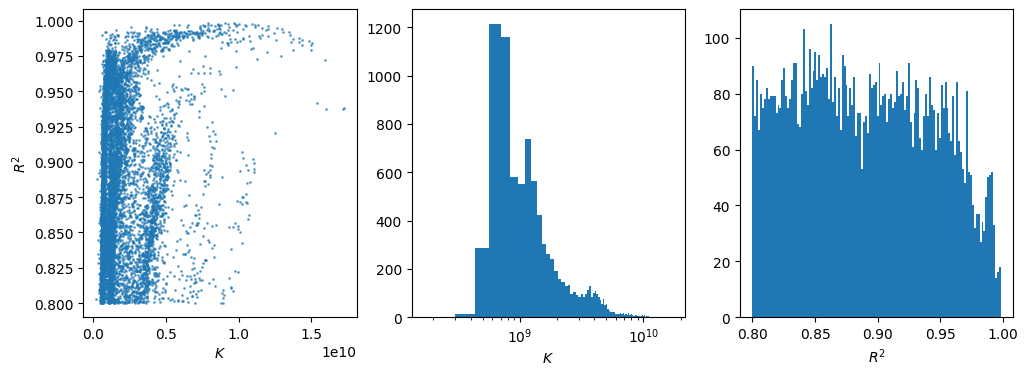

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

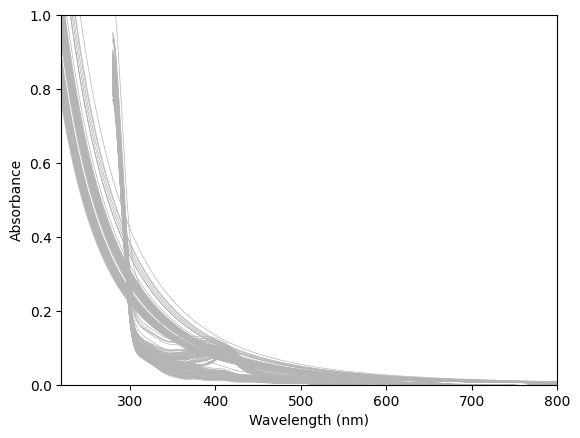

In [25]:
ks = np.concatenate(all_k)

x = pd.concat(
    [
        pd.Series(df.columns, index=df.columns).apply(lambda w : scatter(w, k)) 
        for k in ks[:128]
    ],
    axis=1,
).T 
x = x.reset_index(drop=True)


fig, ax = plt.subplots(1, 1)

plot_traces(x, 
            ax=ax,
           )

plot_traces(df_ns_corrected.iloc[:128, :], 
            ax=ax,
           )

ax.set_ylim(0, 1)
plt.show()

  0%|          | 0/26065 [00:00<?, ?it/s]

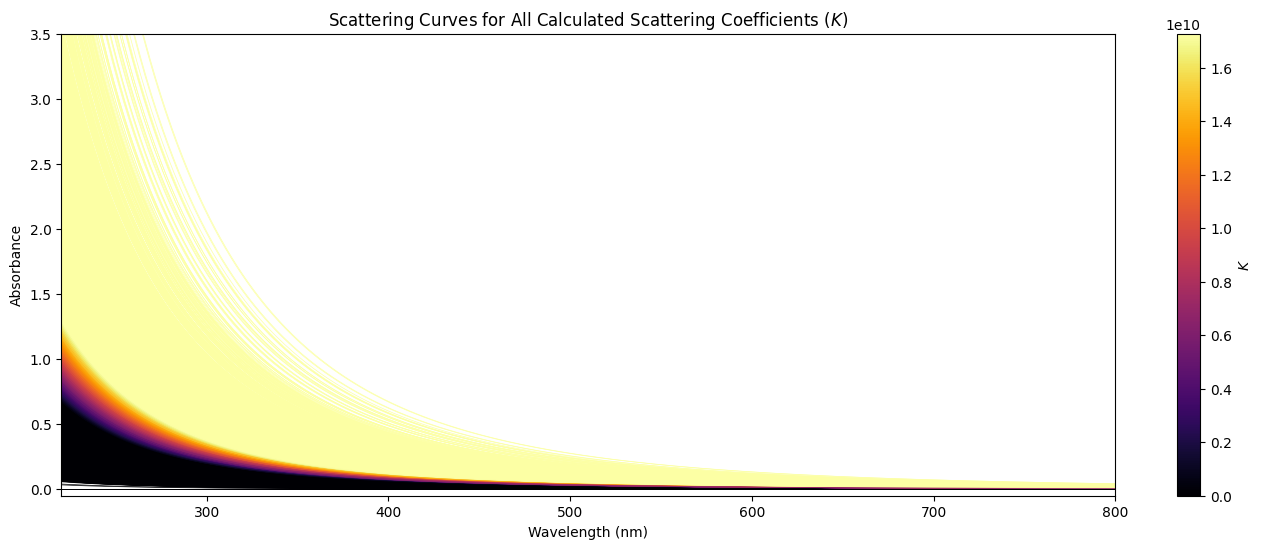

In [26]:
ks = np.concatenate(all_k)

transformer_k = PowerTransformer()
ks_norm = transformer_auc.fit_transform(ks.reshape(-1, 1))
colors_k = np.concatenate([plt.cm.inferno(k) for k in ks_norm])


x = pd.concat([pd.Series(df.columns, index=df.columns).apply(lambda w : scatter(w, k))  for k in ks ],
              axis=1,
              ).T 
x = x.reset_index(drop=True)


fig, ax = plt.subplots(1, 1, figsize=(16,6))

plot_traces(x, 
            ax=ax,
            colors=colors_k,
            title='Scattering Curves for All Calculated Scattering Coefficients ($K$)'
           )

add_cmap(fig, 
         ax, 
         vmin=min(all_k), 
         vmax=max(all_k), 
         label='$K$', 
         orientation='vertical',
         fraction=0.1,
        )

plt.savefig(os.path.join(img_dir, 'ideal-scattering-curves-color-k.png'))
plt.show()

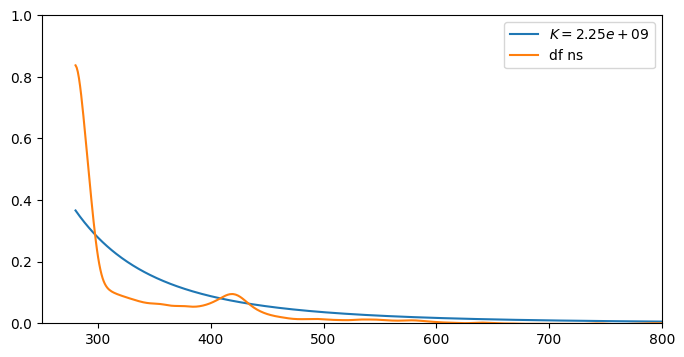

In [71]:
# pd.DataFrame(
#         [[w * (k**-4) for w in df_ns_slice.columns] 
#          for k in all_k_slice[:100]],
#     columns=df_ns_slice.columns,
# )

def scatter(w, k):
    return k * (1 / w**4)
    
k = all_k[2][0]
x = pd.Series(df_ns_corrected.columns,
              index=df_ns_corrected.columns,
             ).apply(lambda w : scatter(w, k))

plt.figure(figsize=(8,4))
plt.plot(x, label=f'$K = {k:.2e}$')
plt.plot(df_ns_corrected.iloc[2, :], label='df ns')
plt.ylim(0, 1)
plt.xlim(250, 800)
plt.legend()
plt.show()

  0%|          | 0/18110 [00:00<?, ?it/s]

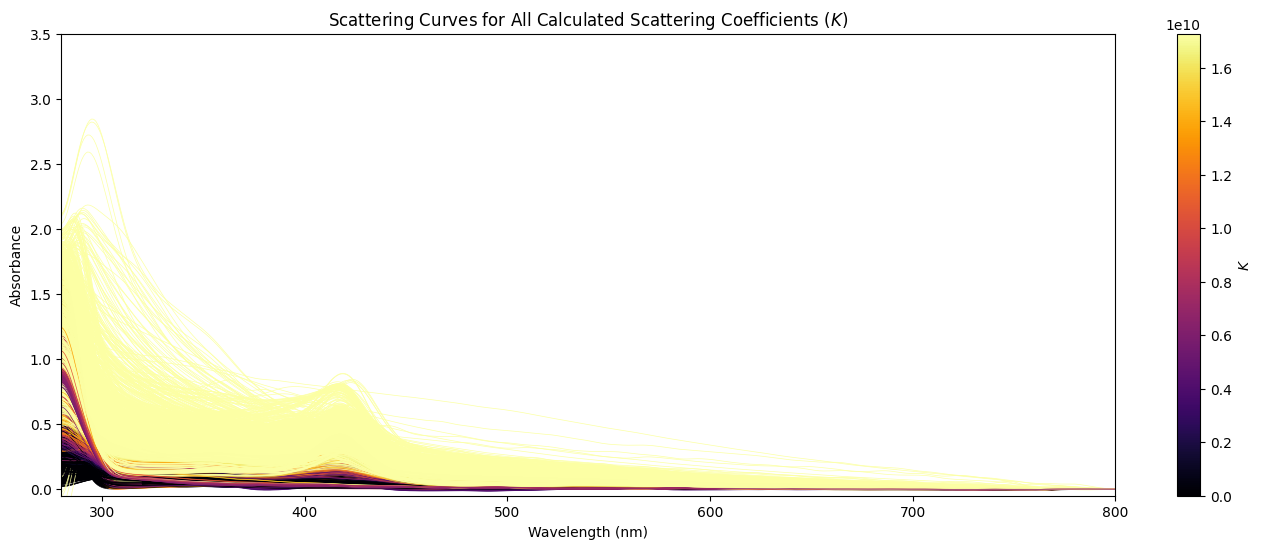

In [75]:
thresh = 1e9

fig, ax = plt.subplots(1, 1, figsize=(16,6))

plot_traces(df_ns_corrected.loc[ks > thresh, :],
            ax=ax,
            colors=colors_k[ks > thresh],
            title='Scattering Curves for All Calculated Scattering Coefficients ($K$)',
            xlim=(280, 800),
           )

add_cmap(fig, 
         ax, 
         vmin=min(all_k), 
         vmax=max(all_k), 
         label='$K$', 
         orientation='vertical',
         fraction=0.1,
        )

plt.savefig(os.path.join(img_dir, 'ideal-scattering-curves-color-k.png'))
plt.show()

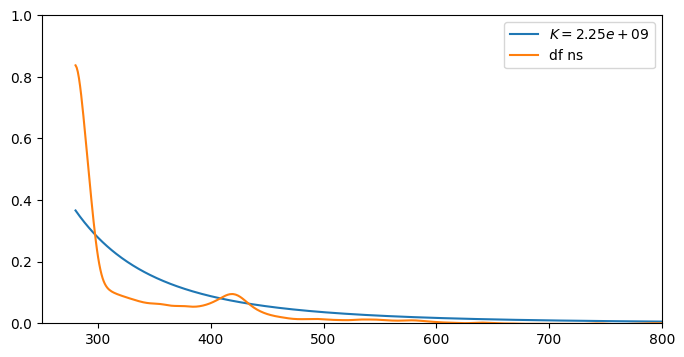

In [88]:

k = np.random.choice(ks)
k = ks[2]
x = pd.Series(df_ns_corrected.columns,
              index=df_ns_corrected.columns,
             ).apply(lambda w : scatter(w, k))

plt.figure(figsize=(8,4))
plt.plot(x, label=f'$K = {k:.2e}$')
plt.plot(df_ns_corrected.iloc[2, :], label='df ns')
plt.ylim(0, 1)
plt.xlim(250, 800)
plt.legend()
plt.show()

In [ ]:
k = all_k[0][0]
x = pd.Series(df_ns_corrected.columns,
              index=df_ns_corrected.columns,
             ).apply(lambda w : scatter(w, k))

plt.figure(figsize=(8,4))
plt.plot(x, label=f'$K = {k:.2e}$')
plt.plot(df_ns_corrected.iloc[2, :], label='df ns')
plt.plot(df_ns_corrected.iloc[rsqs.argmax(), :], label='$max(R^2)$')
plt.plot(df_ns_corrected.iloc[ks.argmax(), :], label='$max(K)$')
plt.ylim(0, 1)
plt.xlim(250, 800)
plt.legend()
plt.show()

In [ ]:

krs = pd.DataFrame([ks, rsqs], index=['k', 'rsq']).T
krs = krs.loc[krs['rsq'] > 0.8, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(x=krs['k'], 
              y=krs['rsq'],
              s=1,
              alpha=0.6,
             )
ax[0].set_xlabel('$K$')
ax[0].set_ylabel('$R^2$')

ax[1].hist(krs['k'], bins=128)
ax[1].set_xscale('log')
ax[1].set_xlabel('$K$')

ax[2].hist(krs['rsq'], bins=128)
ax[2].set_xlabel('$R^2$')

plt.show()

In [90]:
def fit_scatter_curve(data: pd.Series):
    k, cov = optimize.curve_fit(scatter,
                                xdata=row.index,
                                ydata=row
                               )
    y_pred = pd.Series(scatter(row.index, k), index=row.index)
    rsq = r_squared(row, y_pred)
    return k, rsq

krs_trim = pd.DataFrame([dict(zip(['k', 'rsq'], fit_scatter_curve(row[350:]))) for row in df_ns_corrected.iterrows()])
krs_trim

k       rsq
0      [2009942762.678641]  0.534863
1      [2009942762.678641]  0.534863
2      [2009942762.678641]  0.534863
3      [2009942762.678641]  0.534863
4      [2009942762.678641]  0.534863
...                    ...       ...
26060  [2009942762.678641]  0.534863
26061  [2009942762.678641]  0.534863
26062  [2009942762.678641]  0.534863
26063  [2009942762.678641]  0.534863
26064  [2009942762.678641]  0.534863

[26065 rows x 2 columns]

In [93]:
100 * len(df_clear) / len(df_normal)

0.3644734318051026

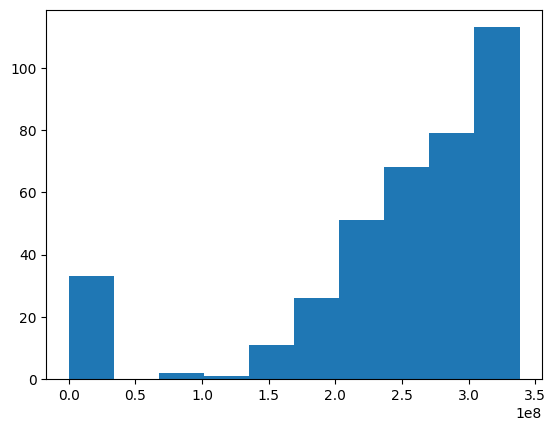

In [123]:
plt.hist(n_largest_k)
plt.show()

array([[0.817341, 0.270954, 0.27039 , 1.      ],
       [0.309935, 0.051407, 0.423721, 1.      ],
       [0.796607, 0.254728, 0.287264, 1.      ],
       ...,
       [0.694627, 0.195021, 0.354388, 1.      ],
       [0.988362, 0.998364, 0.644924, 1.      ],
       [0.54092 , 0.134729, 0.415123, 1.      ]])

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

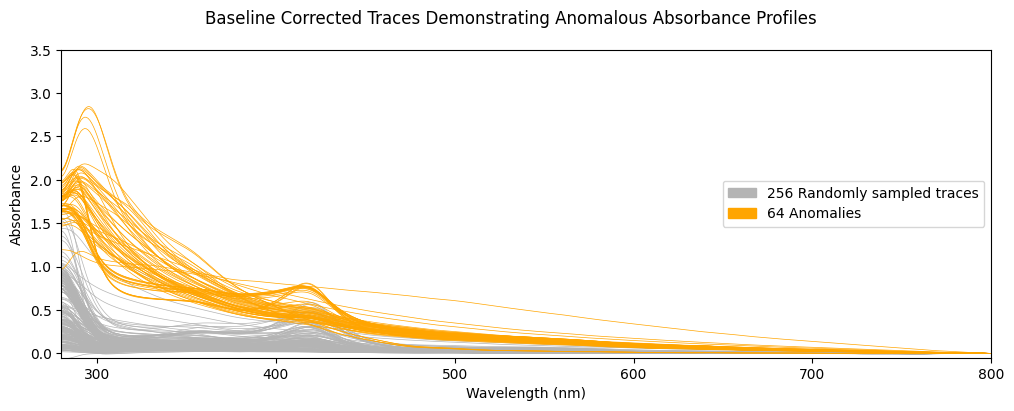

In [220]:
#df_ns_corrected
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
n = 64
n_samples = 256
# idx_n_largest_k = np.argpartition(ks, n)[:n]
# n_largest_k = ks[idx_n_largest_k]
ks_series = pd.Series(ks)
n_largest_k = ks_series.nlargest(n)
idx_n_largest_k = n_largest_k.index


plot_traces(df_ns_corrected.sample(n_samples),
            ax=ax,
            # colors=colors_k[idx_n_largest_k],
           )
plot_traces(df_ns_corrected.loc[idx_n_largest_k, :],
            ax=ax,
            c='orange',
            xlim=(280, 800),
            legend_dict={
                'patch_props': [
                    {'color': '#b4b4b4', 'label': f'{n_samples} Randomly sampled traces'},
                    {'color': 'orange', 'label': f'{n} Anomalies'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

fig.suptitle('Baseline Corrected Traces Demonstrating Anomalous Absorbance Profiles')
#plt.savefig('img_scattering/demo-scattering-effect.png')
plt.show()

  0%|          | 0/64 [00:00<?, ?it/s]

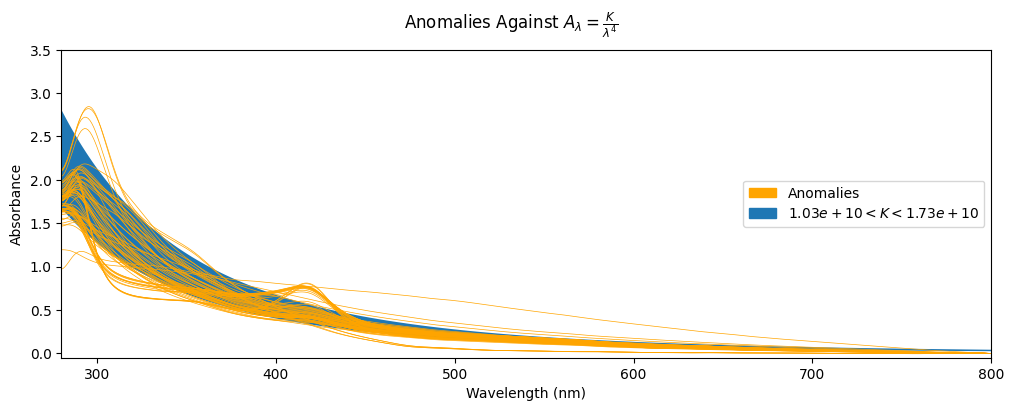

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

x = pd.concat(
    [
        pd.Series(df.columns, index=df.columns).apply(lambda w : scatter(w, k)) 
        for k in n_largest_k
    ],
    axis=1,
).T 



#plot_traces(x,
#            ax=ax,
#            lw=3,
#           )
ax.fill_between(x.columns,
                x.min(),
                x.max(),
               )

plot_traces(df_ns_corrected.loc[idx_n_largest_k, :],
            ax=ax,
            c='orange',
            xlim=(280, 800),
            legend_dict={
                'patch_props': [
                    {'color': 'orange', 'label': 'Anomalies'},
                    {'color': '#1f77b4', 'label': f'${min(n_largest_k):.2e} < K < {max(n_largest_k):.2e}$'},
                ],
                
                'legend_props': {'title': '',   'loc':'right'},
            },
           )

fig.suptitle(r'Anomalies Against $A_{\lambda} = \frac{K}{\lambda^4} $')
plt.savefig('img_scattering/demo-scattering-effect-area.png')
plt.show()

7.3749590489136505

In [183]:
c = plt.rcParams['axes.prop_cycle']
c

cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

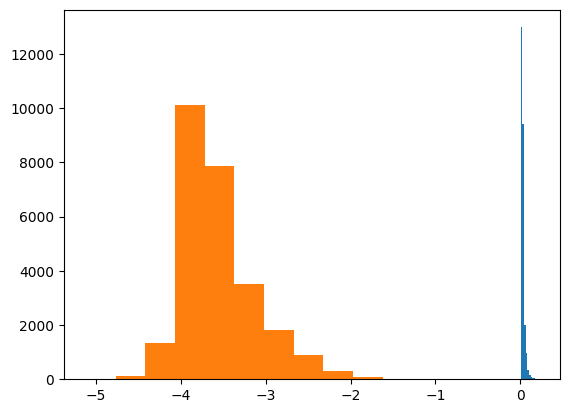

In [270]:
plt.hist(df__slice[800])
plt.hist(np.log(df__slice[800]))
plt.show()

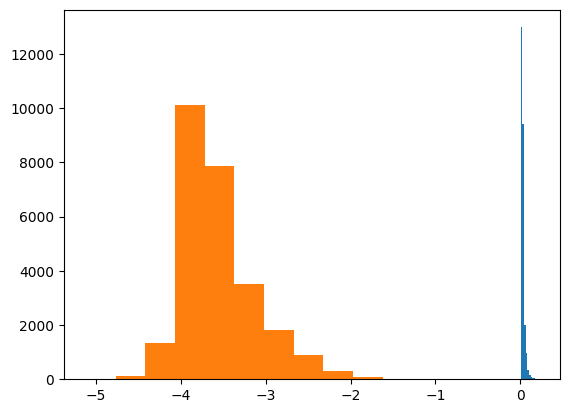

In [270]:
plt.hist(df__slice[800])
plt.hist(np.log(df__slice[800]))
plt.show()

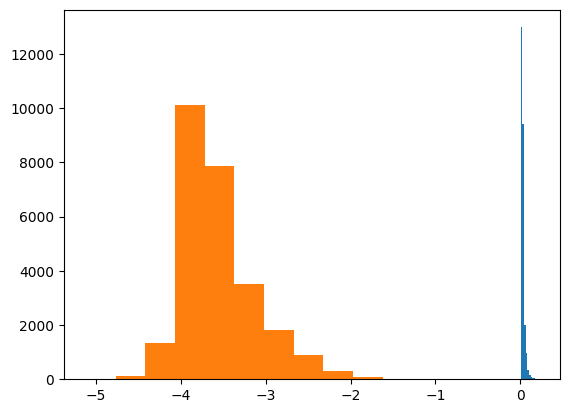

In [270]:
plt.hist(df__slice[800])
plt.hist(np.log(df__slice[800]))
plt.show()